[View in Colaboratory](https://colab.research.google.com/github/aliakh/demo_tensorflow/blob/master/iris_logistic_regression.ipynb)

# Logistic Regression

## Setup



In [0]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
COLUMN_NAMES = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
        
FEATURE_NAMES = COLUMN_NAMES[:-1]
TARGET_NAME = COLUMN_NAMES[-1]

SPECIES_NAMES = ['Iris Setosa', 'Iris Versicolor', 'Iris Virginica']

print("Features: {}".format(FEATURE_NAMES))
print("Target: {}".format(TARGET_NAME))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Target: species


In [3]:
training_file_url = "http://download.tensorflow.org/data/iris_training.csv"
training_dataframe = pd.read_csv(training_file_url, names=COLUMN_NAMES, header=0)

test_file_url = "http://download.tensorflow.org/data/iris_test.csv"
test_dataframe = pd.read_csv(test_file_url, names=COLUMN_NAMES, header=0)

print("Training dataframe:")
display.display(training_dataframe)

print("Test dataframe:")
display.display(test_dataframe)

Training dataframe:


,sepal_length,sepal_width,petal_length,petal_width,species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0
...,...,...,...,...,...
115,5.5,2.6,4.4,1.2,1
116,5.7,3.0,4.2,1.2,1
117,4.4,2.9,1.4,0.2,0
118,4.8,3.0,1.4,0.1,0


Test dataframe:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.9,3.0,4.2,1.5,1
1,6.9,3.1,5.4,2.1,2
2,5.1,3.3,1.7,0.5,0
3,6.0,3.4,4.5,1.6,1
4,5.5,2.5,4.0,1.3,1
...,...,...,...,...,...
25,6.1,3.0,4.6,1.4,1
26,5.2,4.1,1.5,0.1,0
27,6.7,3.1,4.7,1.5,1
28,6.7,3.3,5.7,2.5,2


In [0]:
def preprocess_features(dataframe):
  selected_features = dataframe[[
    "sepal_length",
    "sepal_width",
    "petal_length",
    "petal_width",
  ]]  
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(dataframe):
  processed_targets = pd.DataFrame()
  processed_targets[TARGET_NAME] = dataframe[TARGET_NAME]
  return processed_targets

In [5]:
training_examples = preprocess_features(training_dataframe.head(80))
training_targets = preprocess_targets(training_dataframe.head(80))

validation_examples = preprocess_features(training_dataframe.tail(40))
validation_targets = preprocess_targets(training_dataframe.tail(40))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,sepal_length,sepal_width,petal_length,petal_width
count,80.0,80.0,80.0,80.0
mean,6.0,3.1,4.0,1.3
std,0.9,0.5,1.8,0.8
min,4.4,2.0,1.0,0.1
25%,5.2,2.8,1.7,0.4
50%,6.0,3.0,4.5,1.5
75%,6.7,3.3,5.4,1.9
max,7.9,4.4,6.9,2.5


Validation examples summary:


,sepal_length,sepal_width,petal_length,petal_width
count,40.0,40.0,40.0,40.0
mean,5.5,3.0,3.2,0.9
std,0.7,0.4,1.7,0.7
min,4.4,2.3,1.3,0.1
25%,5.0,2.8,1.5,0.2
50%,5.5,3.0,3.5,1.0
75%,6.0,3.4,4.7,1.4
max,7.7,3.8,6.7,2.5


Training targets summary:


,species
count,80.0
mean,1.2
std,0.8
min,0.0
25%,0.0
50%,1.0
75%,2.0
max,2.0


Validation targets summary:


,species
count,40.0
mean,0.7
std,0.7
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,2.0


## How Would Linear Regression Fare?


In [0]:
def construct_feature_columns_fn(features):
  return set([tf.feature_column.numeric_column(feature) for feature in features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Task 1: Can We Calculate LogLoss for These Predictions?

**Examine the predictions and decide whether or not we can use them to calculate LogLoss.**

`LinearRegressor` uses the L2 loss, which doesn't do a great job at penalizing misclassifications when the output is interpreted as a probability.  For example, there should be a huge difference whether a negative example is classified as positive with a probability of 0.9 vs 0.9999, but L2 loss doesn't strongly differentiate these cases.

In contrast, `LogLoss` penalizes these "confidence errors" much more heavily.  Remember, `LogLoss` is defined as:

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


But first, we'll need to obtain the prediction values. We could use `LinearRegressor.predict` to obtain these.

Given the predictions and that targets, can we calculate `LogLoss`?

### Solution


In [0]:
predict_validation_input_fn = lambda: my_input_fn(
  validation_examples, 
  validation_targets[TARGET_NAME], 
  num_epochs=1, 
  shuffle=False)

#validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
#validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

#_ = plt.hist(validation_predictions)

## Task 2: Train a Logistic Regression Model and Calculate LogLoss on the Validation Set

To use logistic regression, simply use [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) instead of `LinearRegressor`. Complete the code below.

**NOTE**: When running `train()` and `predict()` on a `LinearClassifier` model, you can access the real-valued predicted probabilities via the `"probabilities"` key in the returned dict—e.g., `predictions["probabilities"]`. Sklearn's [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) function is handy for calculating LogLoss using these probabilities.


### Solution

Click below to see the solution.



In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns_fn(training_examples),
      optimizer=my_optimizer,
      n_classes=3
  )
    
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[TARGET_NAME], 
      batch_size=batch_size)
  
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[TARGET_NAME], 
      num_epochs=1, 
      shuffle=False)
  
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, 
      validation_targets[TARGET_NAME], 
      num_epochs=1, 
      shuffle=False)
  
  print("Model training started...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  
  for period in range (0, periods):
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )

    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)

    print("  period %02d : %0.2f" % (period, training_log_loss))

    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
    
  print("Model training finished.")
  
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Model training started...
LogLoss (on training data):
  period 00 : 0.79
  period 01 : 0.63
  period 02 : 0.53
  period 03 : 0.47
  period 04 : 0.42
  period 05 : 0.39
  period 06 : 0.36
  period 07 : 0.34
  period 08 : 0.32
  period 09 : 0.30
Model training finished.


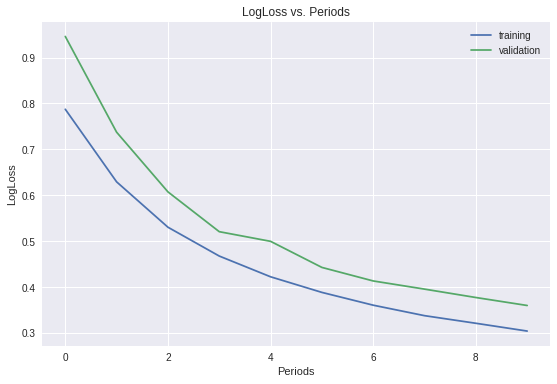

In [10]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.001,
    steps=1000,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 3: Calculate Accuracy and plot a ROC Curve for the Validation Set

A few of the metrics useful for classification are the model [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under the ROC curve (AUC). We'll examine these metrics.

`LinearClassifier.evaluate` calculates useful metrics like accuracy and AUC.

In [11]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("Evaluation metrics: {}".format(evaluation_metrics))
#print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
#print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

Evaluation metrics: {'average_loss': 0.359779, 'accuracy': 0.875, 'global_step': 1000, 'loss': 0.359779}


You may use class probabilities, such as those calculated by `LinearClassifier.predict`,
and Sklearn's [roc_curve](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) to
obtain the true positive and false positive rates needed to plot a ROC curve.

In [0]:
#validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
#validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

#false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(validation_targets, validation_probabilities)
#plt.plot(false_positive_rate, true_positive_rate, label="our model")
#plt.plot([0, 1], [0, 1], label="random classifier")
#_ = plt.legend(loc=2)

**See if you can tune the learning settings of the model trained at Task 2 to improve AUC.**

Often times, certain metrics improve at the detriment of others, and you'll need to find the settings that achieve a good compromise.

**Verify if all metrics improve at the same time.**

### Solution

Click below for a possible solution.

One possible solution that works is to just train for longer, as long as we don't overfit. 

We can do this by increasing the number the steps, the batch size, or both.

All metrics improve at the same time, so our loss metric is a good proxy
for both AUC and accuracy.

Notice how it takes many, many more iterations just to squeeze a few more 
units of AUC. This commonly happens. But often even this small gain is worth 
the costs.

Model training started...
LogLoss (on training data):
  period 00 : 0.54
  period 01 : 0.36
  period 02 : 0.26
  period 03 : 0.20
  period 04 : 0.16
  period 05 : 0.14
  period 06 : 0.12
  period 07 : 0.11
  period 08 : 0.10
  period 09 : 0.10
Model training finished.
Evaluation metrics: {'average_loss': 0.18536654, 'accuracy': 0.95, 'global_step': 20000, 'loss': 0.18536654}


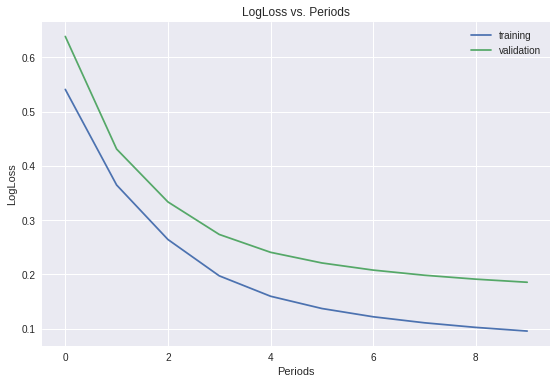

In [13]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.0001,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("Evaluation metrics: {}".format(evaluation_metrics))
#print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
#print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])